In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from haversine import haversine
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score
import warnings
warnings.filterwarnings('ignore')



print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test.csv', 'test', 'sample_submission', 'train', 'train.csv', 'sample_submission.csv']


# 1 Importation des données

In [2]:
# Importation du fichier CSV (en indiquant que la colonne IDENTITY est la colonne id du dataset)
data = pd.read_csv('../input/train.csv') #, index_col = 0)

In [3]:
test = pd.read_csv('../input/test.csv') #, index_col = 0)

In [4]:
test.shape

(625134, 9)

In [5]:
test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


# 2 Analyse des données

In [6]:
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [7]:
data.info

<bound method DataFrame.info of                 id  vendor_id      ...      store_and_fwd_flag trip_duration
0        id2875421          2      ...                       N           455
1        id2377394          1      ...                       N           663
2        id3858529          2      ...                       N          2124
3        id3504673          2      ...                       N           429
4        id2181028          2      ...                       N           435
5        id0801584          2      ...                       N           443
6        id1813257          1      ...                       N           341
7        id1324603          2      ...                       N          1551
8        id1301050          1      ...                       N           255
9        id0012891          2      ...                       N          1225
10       id1436371          2      ...                       N          1274
11       id1299289          2      ...      

In [8]:
test.shape

(625134, 9)

# 3 Preprocessing

In [9]:
# Convertir les dates de timestamp en datetime afin d'extraire d'autres détails importants de la date
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
data['dropoff_datetime'] = pd.to_datetime(data['dropoff_datetime'])

# Convertir les dates de timestamp en datetime afin d'extraire d'autres détails importants de la date
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'])

In [10]:
# Extraction, Calcul et affectation des nouvelles données relative à la pickup_date dans le dataset
data['weekday'] = data.pickup_datetime.dt.weekday_name
data['month'] = data.pickup_datetime.dt.month
data['weekday_num'] = data.pickup_datetime.dt.weekday
data['pickup_hour'] = data.pickup_datetime.dt.hour

# Extraction, Calcul et affectation des nouvelles données relative à la pickup_date dans le dataset
test['weekday'] = test.pickup_datetime.dt.weekday_name
test['month'] = test.pickup_datetime.dt.month
test['weekday_num'] = test.pickup_datetime.dt.weekday
test['pickup_hour'] = test.pickup_datetime.dt.hour

In [11]:
# Fonction de calcul de distance entre les points de départs et les points d'arrivées
# Elle prend en paramètre le dataset, et renvoie un vecteur contenant les distances entre ces points
# Elle applique la méthode de Haversine pour le calcul des distances entre deux coordonnées
def calcul_distance(df):
    pickedup = (df['pickup_latitude'], df['pickup_longitude'])
    dropoff = (df['dropoff_latitude'], df['dropoff_longitude'])
    return haversine(pickedup, dropoff)

In [12]:
# Calcul des distances entre les points de départs et les points d'arrivées
# et les mettant dans une nouvelle colonne distance
data['distance'] = data.apply(lambda x : calcul_distance(x), axis = 1)

In [13]:
test['distance'] = test.apply(lambda x : calcul_distance(x), axis = 1)

In [14]:
data.dtypes.reset_index()

,index,0
0,id,object
1,vendor_id,int64
2,pickup_datetime,datetime64[ns]
3,dropoff_datetime,datetime64[ns]
4,passenger_count,int64
5,pickup_longitude,float64
6,pickup_latitude,float64
7,dropoff_longitude,float64
8,dropoff_latitude,float64
9,store_and_fwd_flag,object


In [15]:
test.dtypes.reset_index()

,index,0
0,id,object
1,vendor_id,int64
2,pickup_datetime,datetime64[ns]
3,passenger_count,int64
4,pickup_longitude,float64
5,pickup_latitude,float64
6,dropoff_longitude,float64
7,dropoff_latitude,float64
8,store_and_fwd_flag,object
9,weekday,object


In [16]:
# Découper les features catégoriques en plusieurs variables numériques / indicatrices

dummy = pd.get_dummies(data.store_and_fwd_flag, prefix='flag')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #enlever la première colonne qui est l'index
data = pd.concat([data,dummy], axis = 1)

dummy = pd.get_dummies(data.vendor_id, prefix='vendor_id')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #enlever la première colonne qui est l'index
data = pd.concat([data,dummy], axis = 1)

dummy = pd.get_dummies(data.month, prefix='month')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #enlever la première colonne qui est l'index
data = pd.concat([data,dummy], axis = 1)

dummy = pd.get_dummies(data.weekday_num, prefix='weekday_num')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #enlever la première colonne qui est l'index
data = pd.concat([data,dummy], axis = 1)

dummy = pd.get_dummies(data.pickup_hour, prefix='pickup_hour')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #enlever la première colonne qui est l'index
data = pd.concat([data,dummy], axis = 1)

dummy = pd.get_dummies(data.passenger_count, prefix='passenger_count')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #enlever la première colonne qui est l'index
data = pd.concat([data,dummy], axis = 1)

In [17]:
test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,weekday,month,weekday_num,pickup_hour,distance
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N,Thursday,6,3,23,2.746430
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N,Thursday,6,3,23,2.759243
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N,Thursday,6,3,23,1.306157
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N,Thursday,6,3,23,5.269095
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N,Thursday,6,3,23,0.960843


In [18]:
# Découper les features catégoriques en plusieurs variables numériques / indicatrices

dummy = pd.get_dummies(test.store_and_fwd_flag, prefix='flag')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #enlever la première colonne qui est l'index
test = pd.concat([test,dummy], axis = 1)

dummy = pd.get_dummies(test.vendor_id, prefix='vendor_id')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #enlever la première colonne qui est l'index
test = pd.concat([test,dummy], axis = 1)

dummy = pd.get_dummies(test.month, prefix='month')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #enlever la première colonne qui est l'index
test = pd.concat([test,dummy], axis = 1)

dummy = pd.get_dummies(test.weekday_num, prefix='weekday_num')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #enlever la première colonne qui est l'index
test = pd.concat([test,dummy], axis = 1)

dummy = pd.get_dummies(test.pickup_hour, prefix='pickup_hour')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #enlever la première colonne qui est l'index
test = pd.concat([test,dummy], axis = 1)

dummy = pd.get_dummies(test.passenger_count, prefix='passenger_count')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #enlever la première colonne qui est l'index
test = pd.concat([test,dummy], axis = 1)

In [19]:
test.shape

(625134, 57)

In [20]:
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,weekday,month,weekday_num,pickup_hour,distance,flag_Y,vendor_id_2,month_2,month_3,month_4,month_5,month_6,weekday_num_1,weekday_num_2,weekday_num_3,weekday_num_4,weekday_num_5,weekday_num_6,pickup_hour_1,pickup_hour_2,pickup_hour_3,pickup_hour_4,pickup_hour_5,pickup_hour_6,pickup_hour_7,pickup_hour_8,pickup_hour_9,pickup_hour_10,pickup_hour_11,pickup_hour_12,pickup_hour_13,pickup_hour_14,pickup_hour_15,pickup_hour_16,pickup_hour_17,pickup_hour_18,pickup_hour_19,pickup_hour_20,pickup_hour_21,pickup_hour_22,pickup_hour_23,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_7,passenger_count_8,passenger_count_9
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,Monday,3,0,17,1.498523,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,Sunday,6,6,0,1.805510,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,Tuesday,1,1,11,6.385107,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,Wednesday,4,2,19,1.485500,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,Saturday,3,5,13,1.188590,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [21]:
data.shape

(1458644, 61)

In [22]:
test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,weekday,month,weekday_num,pickup_hour,distance,flag_Y,vendor_id_2,month_2,month_3,month_4,month_5,month_6,weekday_num_1,weekday_num_2,weekday_num_3,weekday_num_4,weekday_num_5,weekday_num_6,pickup_hour_1,pickup_hour_2,pickup_hour_3,pickup_hour_4,pickup_hour_5,pickup_hour_6,pickup_hour_7,pickup_hour_8,pickup_hour_9,pickup_hour_10,pickup_hour_11,pickup_hour_12,pickup_hour_13,pickup_hour_14,pickup_hour_15,pickup_hour_16,pickup_hour_17,pickup_hour_18,pickup_hour_19,pickup_hour_20,pickup_hour_21,pickup_hour_22,pickup_hour_23,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_9
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N,Thursday,6,3,23,2.746430,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N,Thursday,6,3,23,2.759243,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N,Thursday,6,3,23,1.306157,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N,Thursday,6,3,23,5.269095,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N,Thursday,6,3,23,0.960843,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0


# 4 Analyse univariée
#### On va analyser et étudier les variables une par une

In [23]:
pd.options.display.float_format = '{:.2f}'.format #Basculer l'affichage des floats en format scientifique

In [24]:
data.passenger_count.value_counts()

1    1033540
2     210318
5      78088
3      59896
6      48333
4      28404
0         60
7          3
9          1
8          1
Name: passenger_count, dtype: int64

In [25]:
test.passenger_count.value_counts()

1    443447
2     90027
5     33411
3     25686
6     20521
4     12017
0        23
9         2
Name: passenger_count, dtype: int64

In [26]:
print(data.passenger_count.describe())
print(f'median = {data.passenger_count.median()}')
# On remarque que la moyenne, la médiane et les modes sont presque égaux à 1

count   1458644.00
mean          1.66
std           1.31
min           0.00
25%           1.00
50%           1.00
75%           2.00
max           9.00
Name: passenger_count, dtype: float64
median = 1.0


In [27]:
# Alors on remplace le passenger_count 0 par 1
data['passenger_count'] = data.passenger_count.map(lambda x: 1 if x == 0 else x)

In [28]:
test['passenger_count'] = test.passenger_count.map(lambda x: 1 if x == 0 else x)

In [29]:
test.shape

(625134, 57)

In [30]:
data.passenger_count.value_counts()

1    1033600
2     210318
5      78088
3      59896
6      48333
4      28404
7          3
9          1
8          1
Name: passenger_count, dtype: int64

In [31]:
test.passenger_count.value_counts()

1    443470
2     90027
5     33411
3     25686
6     20521
4     12017
9         2
Name: passenger_count, dtype: int64

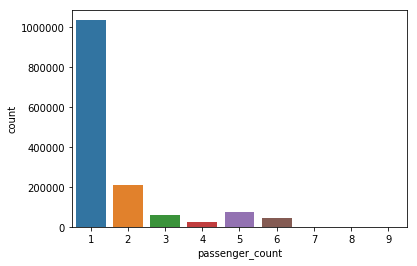

In [32]:
#Nombre de courses par nombre de passagers
sns.countplot(data.passenger_count)
plt.show()

In [33]:
data.dtypes.reset_index()

,index,0
0,id,object
1,vendor_id,int64
2,pickup_datetime,datetime64[ns]
3,dropoff_datetime,datetime64[ns]
4,passenger_count,int64
5,pickup_longitude,float64
6,pickup_latitude,float64
7,dropoff_longitude,float64
8,dropoff_latitude,float64
9,store_and_fwd_flag,object


In [34]:
test.dtypes.reset_index()

,index,0
0,id,object
1,vendor_id,int64
2,pickup_datetime,datetime64[ns]
3,passenger_count,int64
4,pickup_longitude,float64
5,pickup_latitude,float64
6,dropoff_longitude,float64
7,dropoff_latitude,float64
8,store_and_fwd_flag,object
9,weekday,object


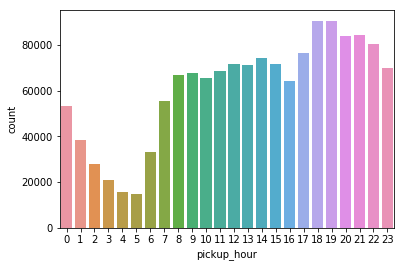

In [35]:
# Distribution des horaires de départs des courses sur 24 heures
sns.countplot(data.pickup_hour)
plt.show()

# 5 Séléction des features

In [36]:
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,weekday,month,weekday_num,pickup_hour,distance,flag_Y,vendor_id_2,month_2,month_3,month_4,month_5,month_6,weekday_num_1,weekday_num_2,weekday_num_3,weekday_num_4,weekday_num_5,weekday_num_6,pickup_hour_1,pickup_hour_2,pickup_hour_3,pickup_hour_4,pickup_hour_5,pickup_hour_6,pickup_hour_7,pickup_hour_8,pickup_hour_9,pickup_hour_10,pickup_hour_11,pickup_hour_12,pickup_hour_13,pickup_hour_14,pickup_hour_15,pickup_hour_16,pickup_hour_17,pickup_hour_18,pickup_hour_19,pickup_hour_20,pickup_hour_21,pickup_hour_22,pickup_hour_23,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_7,passenger_count_8,passenger_count_9
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.98,40.77,-73.96,40.77,N,455,Monday,3,0,17,1.50,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.98,40.74,-74.00,40.73,N,663,Sunday,6,6,0,1.81,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.98,40.76,-74.01,40.71,N,2124,Tuesday,1,1,11,6.39,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.01,40.72,-74.01,40.71,N,429,Wednesday,4,2,19,1.49,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.97,40.79,-73.97,40.78,N,435,Saturday,3,5,13,1.19,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [37]:
#Vérifiez d'abord l'index des features et le label
list(zip( range(0,len(data.columns)),data.columns))

[(0, 'id'),
 (1, 'vendor_id'),
 (2, 'pickup_datetime'),
 (3, 'dropoff_datetime'),
 (4, 'passenger_count'),
 (5, 'pickup_longitude'),
 (6, 'pickup_latitude'),
 (7, 'dropoff_longitude'),
 (8, 'dropoff_latitude'),
 (9, 'store_and_fwd_flag'),
 (10, 'trip_duration'),
 (11, 'weekday'),
 (12, 'month'),
 (13, 'weekday_num'),
 (14, 'pickup_hour'),
 (15, 'distance'),
 (16, 'flag_Y'),
 (17, 'vendor_id_2'),
 (18, 'month_2'),
 (19, 'month_3'),
 (20, 'month_4'),
 (21, 'month_5'),
 (22, 'month_6'),
 (23, 'weekday_num_1'),
 (24, 'weekday_num_2'),
 (25, 'weekday_num_3'),
 (26, 'weekday_num_4'),
 (27, 'weekday_num_5'),
 (28, 'weekday_num_6'),
 (29, 'pickup_hour_1'),
 (30, 'pickup_hour_2'),
 (31, 'pickup_hour_3'),
 (32, 'pickup_hour_4'),
 (33, 'pickup_hour_5'),
 (34, 'pickup_hour_6'),
 (35, 'pickup_hour_7'),
 (36, 'pickup_hour_8'),
 (37, 'pickup_hour_9'),
 (38, 'pickup_hour_10'),
 (39, 'pickup_hour_11'),
 (40, 'pickup_hour_12'),
 (41, 'pickup_hour_13'),
 (42, 'pickup_hour_14'),
 (43, 'pickup_hour_15'),
 

In [38]:
SELECTED_COLUMNS = ['vendor_id', 'vendor_id_2', 
                    'flag_Y', 
                    'pickup_hour', 'distance', 
                    'month','weekday_num',
                    'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
                    'weekday_num_1', 'weekday_num_2', 'weekday_num_3', 'weekday_num_4', 'weekday_num_5', 'weekday_num_6',
                    'passenger_count_1', 'passenger_count_2', 'passenger_count_3', 'passenger_count_4', 'passenger_count_5', 'passenger_count_6',
                    'pickup_hour', 'pickup_hour_1', 'pickup_hour_2','pickup_hour_3', 'pickup_hour_4', 'pickup_hour_5','pickup_hour_6',  'pickup_hour_7', 'pickup_hour_8', 
                    'pickup_hour_9', 'pickup_hour_10', 'pickup_hour_11', 'pickup_hour_12', 'pickup_hour_13', 'pickup_hour_14', 'pickup_hour_15', 'pickup_hour_16', 
                    'pickup_hour_17', 'pickup_hour_18', 'pickup_hour_19', 'pickup_hour_20', 'pickup_hour_21', 'pickup_hour_22', 'pickup_hour_23' ]
X_many_features = data[SELECTED_COLUMNS]
X_many_features.head()
y_many_features = np.log1p(data['trip_duration'])


In [39]:
X_many_features.shape, y_many_features.shape

((1458644, 48), (1458644,))

In [40]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_many_features, y_many_features)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [41]:
cv_scores = -cross_val_score(rf, X_many_features, y_many_features, cv=3, scoring='neg_mean_squared_error')
cv_scores

array([0.25966352, 0.26154706, 0.25931766])

In [42]:
cv_scores.mean()

0.2601760771128753

In [43]:
X_test = test[SELECTED_COLUMNS]
predictions = np.exp(rf.predict(X_test))-np.ones(len(X_test))

X_test.shape
pred = pd.DataFrame(predictions, index=test['id'])
pred.columns = ['trip_duration']
pred.to_csv("submission_.csv")

pd.read_csv('submission_.csv')

,id,trip_duration
0,id3004672,529.47
1,id3505355,571.02
2,id1217141,351.13
3,id2150126,992.23
4,id1598245,274.71
5,id0668992,1063.95
6,id1765014,988.64
7,id0898117,869.30
8,id3905224,2691.22
9,id1543102,492.23
